In [1]:
# Importing all the Required Libraries 

import re
import nltk
import gensim
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
nltk.download('stopwords')
import matplotlib.pyplot as plt
from keras.utils import np_utils
tqdm.pandas(desc="progress-bar")
from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.preprocessing import sequence
from gensim.models.word2vec import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Flatten, Dense
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Reading the Data into a Pandas Dataframe

df = pd.read_csv('/content/cleaned_review_beauty.csv')

In [3]:
# Data Structuring 

def review_map(review):
  '''
  Input: review
  Output : label
  '''
  if review == "good":
    review = 1
  else:
    review = 0
  return review

df['rating_class'] = df['rating_class'].apply(review_map)

In [4]:
# Getting Categorical Data and Independent variable
X = df['clean_text']
y = df['rating_class']

In [5]:
df['clean_text'][:4]

0    choose one product take care face rest life wo...
1    make skin lovely smooth woman near need help g...
2    work well reasonable price use regenerating se...
3    work lady try many product totally disappointe...
Name: clean_text, dtype: object

# Tokenizer

In [6]:
samples = X

# Creating Object for Tokenizer
tokenizer = Tokenizer(lower=True, split=' ') 
tokenizer.fit_on_texts(samples) 
sequences = tokenizer.texts_to_sequences(samples)

# Getting word_index dictionary
word_index = tokenizer.word_index 
print(f'Unique Tokens:\n{len(word_index)}')

Unique Tokens:
27315


In [7]:
reverse_word_index = dict()
for key, value in word_index.items():
  reverse_word_index[value] = key

# Dictonary comprehension 
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".

decoded_review_list = []
for index in sequences[0]:
  # dictionary.get(key, value)
  val = reverse_word_index.get(index-3, '?') # If key does not exist, value (?) is returned
  decoded_review_list.append(val)

decoded_review = ' '.join(decoded_review_list)
decoded_review

'true make not thick difference try glove choice get notice volcanic notice version hair moisturize african hair arrive positive wash good love ? product notice suggest tousle notice thing something control clear may evenly butter ? hair sometimes shower even ? honest go smell shave sculpt except day no every could type notice dove greasy idea hair good one break ? like review x daily heat hair ? notice bebelush intense needling reason make highly blackhead ? product make make mascara stuff strap product super dark treatment not say quit lie work african long true make try without glove choice get direct'

In [8]:
def sequence_to_text(sequence):
    words_list =  []
    for letter in sequence:
      words_list.append(reverse_word_index.get(letter))
    return words_list

my_text = list(map(sequence_to_text, sequences))

# Word2Vec and Simple Neural Network

In [9]:
word2vec = gensim.models.Word2Vec(my_text,
                                  size=100,
                                  window=10,
                                  min_count=1)
word2vec.train(my_text, total_examples=25026, epochs=10)

(16831162, 20239020)

In [10]:
# Creating dictionary of synonms 

catch_words = ['feel', 'good', 'product', 'cheap', 'beauty', 'bad', 'skin', 'fragrance']
similar_word_dict = dict()
for word in catch_words:
  synonm_list =[]
  for item in word2vec.wv.most_similar([word], topn=5):
    synonm_list.append(item[0])
  similar_word_dict[word] = synonm_list
similar_word_dict

{'bad': ['terrible', 'awful', 'horrible', 'either', 'good'],
 'beauty': ['haircare', 'skincare', 'obsess', 'junkie', 'diy'],
 'cheap': ['drugstore', 'expensive', 'pricy', 'walmart', 'store'],
 'feel': ['feeling', 'afterwards', 'film', 'leave', 'afterward'],
 'fragrance': ['scent', 'aroma', 'odor', 'smell', 'perfume'],
 'good': ['great', 'decent', 'ok', 'okay', 'nice'],
 'product': ['products', 'brand', 'renovated', 'adovia', 'however'],
 'skin': ['face', 'complexion', 'breakout', 'facial', 'redness']}

In [11]:
words_list = []
for key, value in similar_word_dict.items():
  iter_list = []
  summ = [key] + value
  words_list = words_list + summ


wvs = word2vec.wv[words_list]

# Create Object for TSNE class 
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)

T = tsne.fit_transform(wvs)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


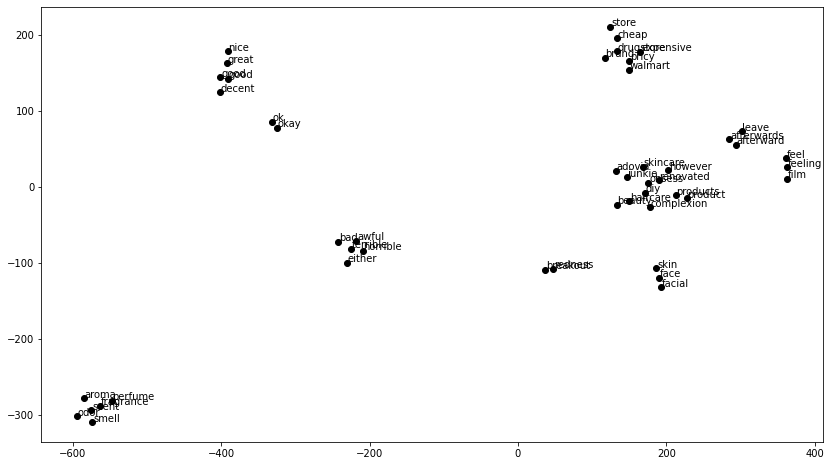

In [12]:
# Plotting TSNE graphs 

labels = words_list
plt.figure(figsize=(14, 8))
X_coord = T[:, 0]
y_coord = T[:, 1]
color = 'black'
plt.scatter(X_coord, y_coord, c=color)

for label, x, yt in zip(labels, X_coord, y_coord):
    plt.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points')

We generated word vectors for words using Word2Vec. <br>
The model has 25026 unique words with vectors of length 100.<br>
<br>
Now, we will feed this generated dense vectors (word embeddings) to a simple neural network to predict values. 

In [13]:
max_review_len = 200 
max_words = len(word_index.keys()) 

len_train_set = 15000
len_val_set = 9509
data = pad_sequences(sequences, maxlen=max_review_len)

# Shuffling data beacause it is ordered and splitting into train and validation sets
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

categorical_data = data[indices]
independent_var = y[indices]

# Splitting the Dataset into Train and Val sets 
X_train = categorical_data[:len_train_set]
X_val = categorical_data[len_train_set: len_train_set + len_val_set]

y_train = y[:len_train_set]
y_val = y[len_train_set: len_train_set + len_val_set]

In [14]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)
print('Shape of training data: ', X_train.shape)
print('Shape of validation data: ', X_val.shape)

Shape of data tensor: (28576, 200)
Shape of label tensor: (28576,)
Shape of training data:  (15000, 200)
Shape of validation data:  (9509, 200)


In [15]:
embedding_dim = 100

# Matrix initialization
embedding_matrix = np.zeros((max_words+1, embedding_dim))
for word , index in word_index.items():
    embedding_vector = word2vec.wv[word]
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

The Embedding layer is best understood as a dictionary mapping integer indices (which represent specific word) to dense vectors. It looks up these input integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.
<br>
<br>

The Embedding layer takes input as a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15). All sequences in a batch must have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.
<br>
<br>

This layer returns a 3D floating point tensor, of shape (samples, sequence_length, embedding_dimensionality). Such a 3D tensor can then be processed by a RNN layer or a 1D convolution layer
<br>
<br>

When you instantiate an Embedding layer, its weights (its internal dictionary of token vectors) are initially random, just like with any other layer. During training, these word vectors will be gradually adjusted through a technique called backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for.

In [16]:
embedding_matrix.shape

(27316, 100)

In [17]:
# Model Architecture
model = Sequential()
model.add(Embedding(max_words+1, embedding_dim, input_length=max_review_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          2731600   
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 32)                640032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,371,665
Trainable params: 3,371,665
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [19]:
optimizer = 'rmsprop'
loss = 'binary_crossentropy'

model.compile(optimizer= optimizer,
              loss= loss,
              metrics=['acc'])

# Getting model training history
hyper_param = {'epochs': 12, 'batch_size': 32}
history = model.fit(X_train, y_train,
                    epochs= hyper_param['epochs'],
                    batch_size= hyper_param['batch_size'],
                    validation_data=(X_val, y_val))

Epoch 1/12
469/469 [==============================] - 9s 18ms/step - loss: 0.5910 - acc: 0.7580 - val_loss: 0.5605 - val_acc: 0.7757
Epoch 2/12
469/469 [==============================] - 7s 14ms/step - loss: 0.4537 - acc: 0.7825 - val_loss: 0.6329 - val_acc: 0.7462
Epoch 3/12
469/469 [==============================] - 7s 15ms/step - loss: 0.3054 - acc: 0.8593 - val_loss: 0.7951 - val_acc: 0.6994
Epoch 4/12
469/469 [==============================] - 6s 14ms/step - loss: 0.1712 - acc: 0.9268 - val_loss: 1.1228 - val_acc: 0.6873
Epoch 5/12
469/469 [==============================] - 7s 14ms/step - loss: 0.0831 - acc: 0.9688 - val_loss: 1.6218 - val_acc: 0.6703
Epoch 6/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0410 - acc: 0.9875 - val_loss: 2.0740 - val_acc: 0.6700
Epoch 7/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0191 - acc: 0.9953 - val_loss: 2.6240 - val_acc: 0.6756
Epoch 8/12
469/469 [==============================] - 7s 16ms/step - 

In [22]:
# Getting metrics from model training history
# Accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

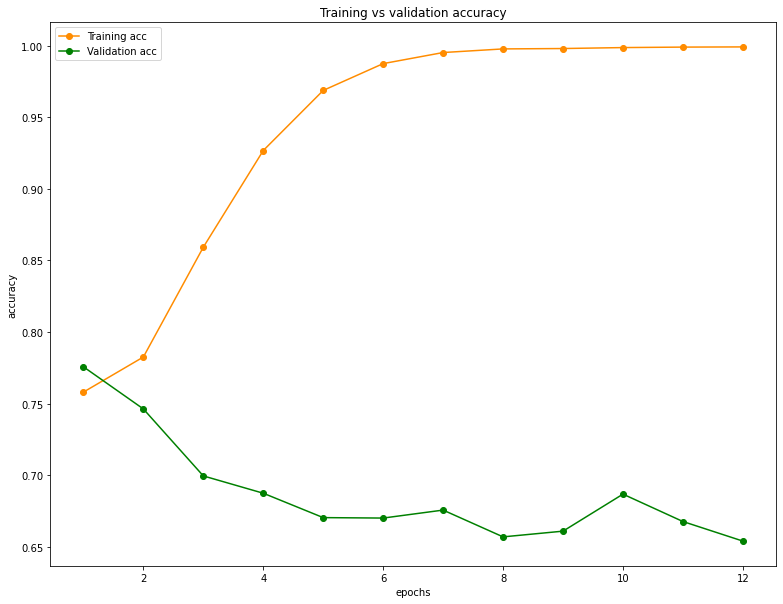

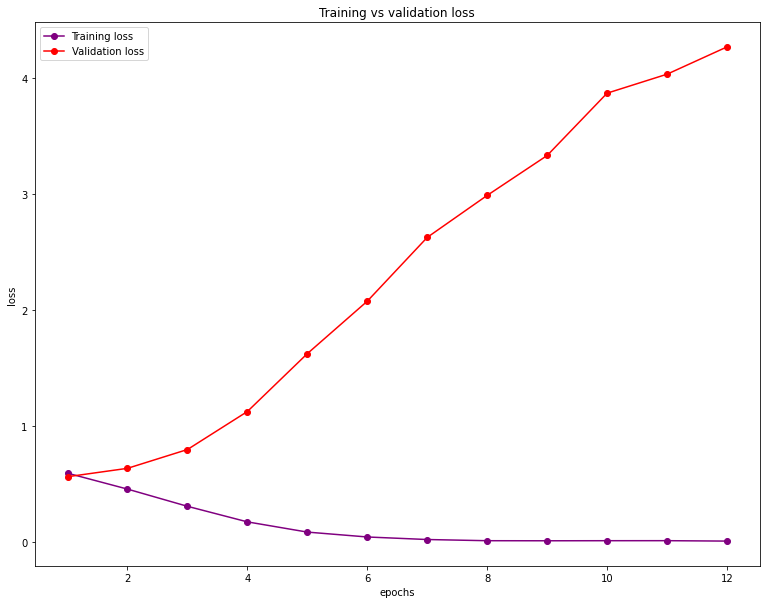

In [23]:
# Plotting 
# Train accuracy vs Validation accuracy
plt.figure(figsize=(13,10))
plt.plot(epochs, acc, color= "darkorange", linestyle= "solid", marker= "o", label='Training acc')
plt.plot(epochs, val_acc, color= 'green', marker= 'o', label='Validation acc')
plt.title('Training vs validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

# Create a New figure
plt.figure(figsize=(13, 10))

# Train loss vs validation loss
plt.plot(epochs, loss, color= "purple", marker= "o", label='Training loss')
plt.plot(epochs, val_loss, color="red", marker= "o", label='Validation loss')
plt.title('Training vs validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

Given small number of Training set, Variance is high and model starts to quickly overfit.